In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 941.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00


In [3]:
import os
import math
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

In [4]:
directory = '/content/drive/MyDrive/Thesis'
data_dir = directory + "/Data"
models_dir = directory + "/models"

In [5]:
distance = pd.read_csv(f'{data_dir}/distance_matrix_centroids.csv')

In [6]:
distance['end_station_cluster'].min()

74

In [7]:
loaded = np.load(f'{data_dir}/demand_graphs.pkl.npz')
demand_graphs = [loaded[f'arr_{i}'] for i in range(0, 8758)]

In [ ]:
adj_matrices = torch.tensor(demand_graphs)

# Number of stations
num_stations = adj_matrices.shape[1]

<ipython-input-8-4adbaaf13251>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  adj_matrices = torch.tensor(demand_graphs)


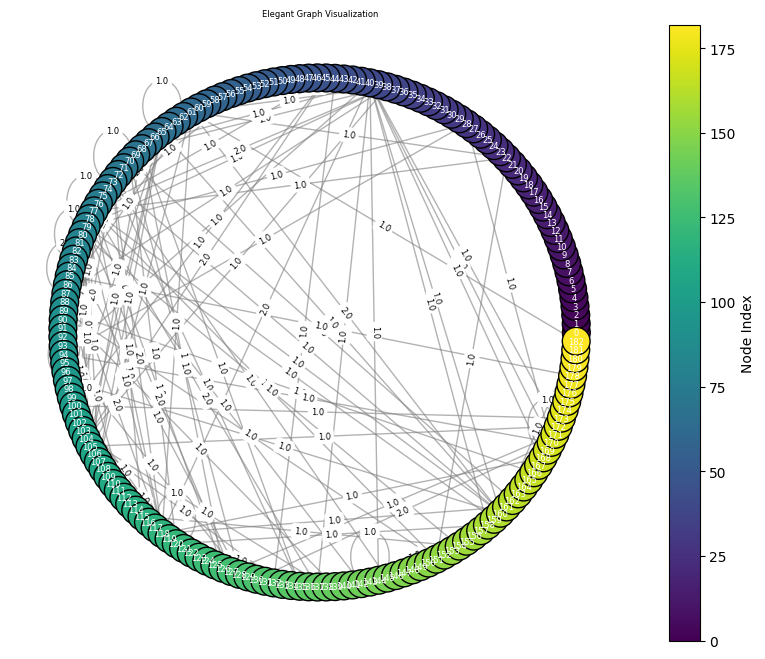

In [29]:
#demand_graphs[0]
import networkx as nx
graph = nx.from_numpy_array(np.array(demand_graphs[60]))


# Choose a layout (spring layout for elegance)
pos = nx.circular_layout(graph)

# Draw nodes with a colormap
plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    graph, pos,
    node_size=400,
    node_color=range(len(graph.nodes)),
    cmap=plt.cm.viridis,
    edgecolors='black'
)

# Draw edges
edges = nx.draw_networkx_edges(
    graph, pos,
    width=1,
    alpha=0.6,
    edge_color="gray"
)

# Draw labels
labels = nx.draw_networkx_labels(
    graph, pos,
    font_size=6,
    font_color="white"
)

# Add edge labels if needed
edge_labels = nx.draw_networkx_edge_labels(
    graph, pos,
    edge_labels={(u, v): f"{graph[u][v]['weight']}" for u, v in graph.edges if 'weight' in graph[u][v]},
    font_size=6
)

# Title and colorbar
plt.title("Elegant Graph Visualization", fontsize=6)
plt.colorbar(nodes, label="Node Index")
plt.axis("off")
plt.show()


In [ ]:
num_stations

183

In [ ]:
del demand_graphs

In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

# Convert adjacency matrices to PyTorch Geometric format for each hour
data_list = []

for i in range(adj_matrices.shape[0]):  # Iterate over each hour
    adj_matrix = adj_matrices[i]

    # Convert dense adjacency matrix to edge_index (sparse representation)
    edge_index, edge_attr = dense_to_sparse(adj_matrix)
    # Use an identity matrix for node features (can be replaced with other features)
    x = torch.eye(num_stations)
    # Create a Data object
    data = Data(x=adj_matrix.float(), edge_index=edge_index, edge_attr=edge_attr)
    data_list.append(data)

print(data_list[0])

for data in data_list:
    data.edge_attr = data.edge_attr.float()

Data(x=[183, 183], edge_index=[2, 57], edge_attr=[57])


In [ ]:
x.dtype

torch.float32

In [ ]:
#data_list[360].to_dict()['edge_attr']

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GNNForDemandPrediction(torch.nn.Module):
    def __init__(self, in_channels, out_channels=50, h1=100, dropout_prob=0.2):
        super(GNNForDemandPrediction, self).__init__()
        self.conv1 = GCNConv(in_channels, h1)
        self.conv2 = GCNConv(h1, out_channels)
        #self.fc_embed = torch.nn.Linear(out_channels, in_channels)
        self.fc = torch.nn.Linear(out_channels, 1)  # Predict demand for each edge (regression)
        self.dropout_prob = dropout_prob

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # First and second GCN layers
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.conv2(x, edge_index)

        # Calculate edge embeddings: take the embeddings of node pairs and aggregate them
        edge_embeddings = (x[edge_index[0]] + x[edge_index[1]]) / 2


        # Predict demand using a fully connected layer
        predicted_demand = self.fc(edge_embeddings).squeeze()  # Shape: [num_edges]

        return predicted_demand  # Return predicted demand for each edge

    # New method to extract node embeddings
    def get_node_embeddings(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply GCN layers to get node embeddings
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)

        #edge_embeddings = (x[edge_index[0]] + x[edge_index[1]]) / 2

        #x = self.fc(edge_embeddings).squeeze()

        return x

In [ ]:
# Instantiate the model
model = GNNForDemandPrediction(
    in_channels=num_stations,
    h1=100,
    out_channels=50
  )

# Define the loss function (MSE for regression) and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [ ]:
# Training function
def train(model, data_list, optimizer, criterion, epochs=100):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0  # Keep track of total loss

        # Loop over the data (for each hour)
        for data in data_list:
            optimizer.zero_grad()  # Clear the gradients
            # Forward pass: predict demand for this hour
            predicted_demand = model(data)
            # Calculate loss (difference between predicted and actual demand)
            loss = criterion(predicted_demand, data.edge_attr)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(data_list)}')

# Train the model using data from all hours
train(model, data_list, optimizer, criterion, epochs=100)

Epoch 0, Loss: 0.21652368250796478
Epoch 10, Loss: 0.21282433674464835
Epoch 20, Loss: 0.21424206645820662
Epoch 30, Loss: 0.21373868439235422
Epoch 40, Loss: 0.2147236735004955
Epoch 50, Loss: 0.2151580507590793
Epoch 60, Loss: 0.2138966602649036


In [ ]:
# Testing the model (evaluation mode)
def test(model, data_list):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No need to track gradients during testing
        for data in data_list:
            predicted_demand = model(data)  # Forward pass
            loss = criterion(predicted_demand, data.edge_attr)  # Compute loss
            total_loss += loss.item()

    print(f'Test Loss: {total_loss / len(data_list)}')

# Test the model
test(model, data_list)

Test Loss: 0.2319716435366785


In [ ]:
f"{datetime.datetime.now()}"

'2024-11-02 14:35:41.061425'

In [ ]:
torch.save(model.state_dict(), f'{models_dir}/gnn_cnn_{datetime.datetime.now()}.pth')



In [ ]:
model

GNNForDemandPrediction(
  (conv1): GCNConv(183, 100)
  (conv2): GCNConv(100, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
model.get_node_embeddings(data_list[i])[0].shape

torch.Size([50])

In [ ]:
model.get_node_embeddings(data_list[i])

tensor([[-0.0548, -0.0327, -0.0491,  ..., -0.0474,  0.0586, -0.0672],
        [-0.0548, -0.0327, -0.0491,  ..., -0.0474,  0.0586, -0.0672],
        [-0.0548, -0.0327, -0.0491,  ..., -0.0474,  0.0586, -0.0672],
        ...,
        [-0.0548, -0.0327, -0.0491,  ..., -0.0474,  0.0586, -0.0672],
        [-0.0548, -0.0327, -0.0491,  ..., -0.0474,  0.0586, -0.0672],
        [-0.0548, -0.0327, -0.0491,  ..., -0.0474,  0.0586, -0.0672]],
       grad_fn=<AddBackward0>)

In [ ]:
for i in range(len(data_list)):
  print((model.get_node_embeddings(data_list[i])))

188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f'{data_dir}/gnn_cnn4.pth')

In [ ]:
model = GNNForDemandPrediction(
    in_channels=num_stations,
    h1=100,
    h2=80,
    h3=60,
    out_channels=50
)

In [ ]:
model.load_state_dict(torch.load(f'{data_dir}/gnn_cnn4.pth'))

<ipython-input-37-41fcb6f99048>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{data_dir}/gnn_cnn4.pth'))


<All keys matched successfully>

In [ ]:
data_list[i].to_dict()['edge_index']

tensor([[  3,   3,  19,  21,  22,  23,  28,  28,  28,  28,  28,  30,  30,  30,
          38,  38,  38,  40,  40,  40,  40,  40,  40,  40,  45,  45,  50,  50,
          53,  54,  54,  54,  59,  61,  61,  61,  61,  61,  61,  62,  62,  62,
          62,  64,  64,  64,  64,  64,  64,  66,  66,  66,  66,  68,  71,  71,
          71,  71,  77,  77,  77,  77,  77,  77,  77,  80,  80,  81,  81,  81,
          81,  81,  81,  81,  81,  81,  83,  83,  83,  83,  83,  83,  83,  83,
          83,  83,  83,  83,  83,  84,  84,  84,  86,  86,  87,  87,  87,  87,
          87,  88,  88,  88,  88,  88,  88,  88,  88,  90,  90,  90,  90,  90,
          90,  90,  90,  90,  90,  93,  93,  94,  94,  98,  99, 100, 100, 100,
         100, 101, 101, 101, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104,
         104, 104, 104, 104, 105, 105, 108, 108, 108, 108, 108, 108, 108, 108,
         108, 108, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 122, 122,
         122, 122, 122, 122, 125, 127, 127, 130, 131

In [ ]:
for i in range(2000):
  print(len(data_list[i].to_dict()['edge_attr']))

57
136
116
30
13
11
18
20
36
55
88
135
161
209
212
235
212
110
92
55
53
46
35
41
24
16
13
10
11
9
11
26
55
87
153
139
198
220
208
191
168
148
120
71
46
66
61
27
20
12
10
2
10
21
54
105
156
136
140
146
164
192
156
153
121
120
91
61
30
36
18
13
7
6
4
2
11
18
39
93
136
122
103
128
135
123
144
156
237
271
223
133
86
73
45
24
19
11
9
9
12
24
64
125
169
156
123
143
190
158
163
213
254
269
233
176
107
77
54
42
16
8
11
3
9
18
69
143
218
188
136
154
185
158
179
204
252
276
229
169
112
76
48
29
12
8
3
12
10
21
51
96
133
107
59
91
110
128
165
200
285
300
234
152
114
87
80
55
46
26
28
5
13
8
21
40
88
139
217
250
290
291
318
271
296
216
136
138
102
66
53
55
44
36
19
19
8
9
22
37
68
114
177
261
280
256
321
280
308
226
124
103
100
65
52
38
19
11
10
11
11
21
62
156
240
191
127
142
181
176
172
203
281
317
245
166
118
87
49
23
16
9
7
4
7
18
72
175
272
169
148
158
192
173
184
258
298
355
292
222
146
94
72
47
30
16
12
5
8
22
70
177
261
204
171
172
219
191
234
229
289
359
270
221
153
120
73
37
25
18
10
3
9

In [ ]:
model.eval()

GNNForDemandPrediction(
  (conv1): GCNConv(188, 100)
  (conv2): GCNConv(100, 80)
  (conv3): GCNConv(80, 60)
  (conv4): GCNConv(60, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
loaded = np.load(f'{data_dir}/demand_graphs.pkl.npz')
demand_graphs = [loaded[f'arr_{i}'] for i in range(8760, 9760)]
adj_matrices = torch.tensor(demand_graphs)

from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

# Convert adjacency matrices to PyTorch Geometric format for each hour
data_list_input = []

for i in range(adj_matrices.shape[0]):  # Iterate over each hour
    adj_matrix = adj_matrices[i]

    # Convert dense adjacency matrix to edge_index (sparse representation)
    edge_index, edge_attr = dense_to_sparse(adj_matrix)

    # Use an identity matrix for node features (can be replaced with other features)
    x = torch.eye(num_stations)

    # Create a Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data_list_input.append(data)

print(data_list_input[0])

for data in data_list_input:
    data.edge_attr = data.edge_attr.float()

Data(x=[188, 188], edge_index=[2, 179], edge_attr=[179])


In [ ]:
for data in data_list_input:
  m = model.get_node_embeddings(data)
  print(m[6])

  print()
  #[6]

#.shape

Streaming output truncated to the last 5000 lines.
         4.1210e-02,  2.2405e-02, -7.6899e-02,  2.9430e-02,  6.1244e-02,
         2.9741e-02, -1.9238e-02,  8.3620e-02, -2.8631e-02, -5.4592e-02,
         2.2581e-02, -7.1912e-02,  5.7599e-02, -5.5164e-02, -5.7451e-02,
        -1.3684e-01, -2.7002e-02,  3.9655e-02,  6.9899e-02,  2.6385e-07,
        -9.0836e-02, -7.6720e-02, -4.2684e-02, -8.8408e-02,  7.4278e-02,
         2.5705e-01, -7.2568e-02,  9.4929e-02,  5.3460e-02,  5.6016e-02],
       grad_fn=<SelectBackward0>)

tensor([ 6.5043e-02,  6.1028e-02, -6.4026e-02,  8.6542e-02, -3.0812e-02,
         3.1783e-02,  1.0259e-05,  6.3434e-02,  5.0898e-02,  4.5800e-02,
         4.4471e-02, -7.3395e-02,  8.5991e-02,  9.7119e-02, -3.4149e-02,
         7.5424e-02,  3.9552e-02, -3.2949e-02, -8.5411e-02,  4.3779e-02,
         4.1210e-02,  2.2405e-02, -7.6899e-02,  2.9430e-02,  6.1244e-02,
         2.9741e-02, -1.9238e-02,  8.3620e-02, -2.8631e-02, -5.4592e-02,
         2.2581e-02, -7.1912e-02,  5.

KeyboardInterrupt: 

In [ ]:
data_list[300].to_dict()['edge_attr']

tensor([1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 2., 1., 1., 2., 2., 3., 1., 1., 1., 1., 1., 1., 2., 3.,
        1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])

In [ ]:
model(data_list[12])

tensor([1.2584, 1.4187, 1.2692, 1.2386, 1.2737, 1.4849, 1.5614, 1.5522, 1.6454,
        1.4131, 1.4009, 1.2386, 1.2964, 1.2584, 1.2304, 1.2622, 1.2304, 1.2304,
        1.4105, 1.4642, 1.5222, 1.3701, 1.2386, 1.3000, 1.2963, 1.3805, 1.3281,
        1.2996, 1.2661, 1.2529, 1.2940, 1.2642, 1.4775, 1.6878, 1.5028, 1.5853,
        1.5329, 1.6433, 1.4820, 1.5067, 1.3422, 1.2612, 1.2584, 1.4187, 1.3925,
        1.5853, 1.3422, 1.5408, 1.3720, 1.4042, 1.3511, 1.3977, 1.5011, 1.3958,
        1.3607, 1.2798, 1.3677, 1.4109, 1.3779, 1.3494, 1.3315, 1.3193, 1.3494,
        1.2938, 1.4363, 1.4520, 1.4632, 1.3677, 1.2584, 1.3595, 1.5923, 1.4898,
        1.5385, 1.3753, 1.4290, 1.5399, 1.4027, 1.5222, 1.4413, 1.5408, 1.4599,
        1.5988, 1.5978, 1.4622, 1.4771, 1.4967, 1.4002, 1.3795, 1.2584, 1.4255,
        1.4765, 1.5315, 1.4791, 1.4106, 1.4400, 1.5400, 1.2651, 1.2695, 1.3688,
        1.2703, 1.2397, 1.3534, 1.3790, 1.4208, 1.2612, 1.5517, 1.5604, 1.6423,
        1.6783, 1.6817, 1.5482, 1.5900, 